In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

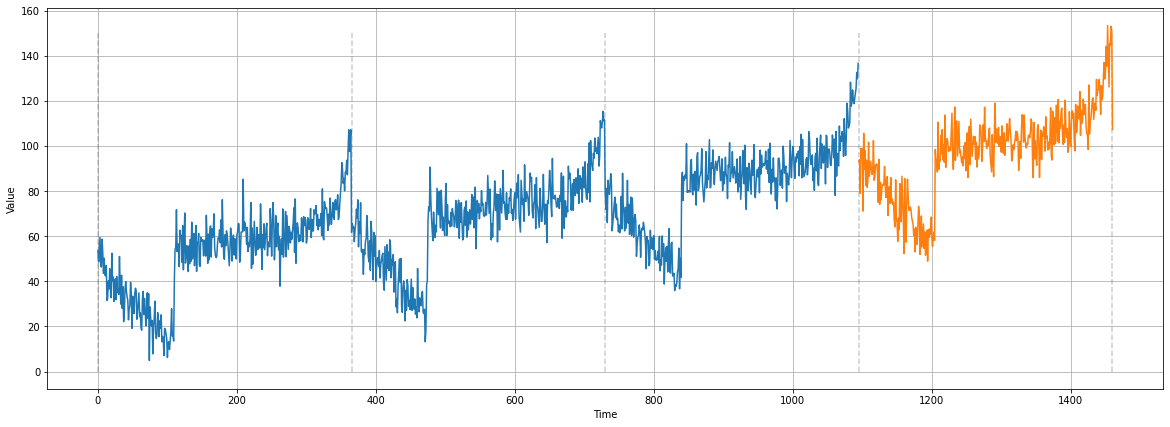

In [81]:
def trend(time, slope):
  return time * slope

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.3,
                    np.cos((season_time + 0.5) * np.pi) * 2.5,
                    (season_time**20) * 2)

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

num_years = 4

time = np.arange(num_years * 365 + 1)
baseline = 50
slope = 0.04
amplitude = 20
period = 365

series = baseline + trend(time, slope) + seasonality(time, period, amplitude)
noise_level = 7
series += white_noise(time, noise_level, 42)

split_time = 3 * 365
time_train = time[:split_time]
x_train = series[:split_time]
time_val = time[split_time:]
x_val = series[split_time:]

plt.figure(figsize=(20,7))
plot_series(time_train, x_train)
plot_series(time_val, x_val)
for year in range(num_years+1):
  plt.vlines(365 * year, 0, 150, linestyles='dashed', alpha=0.2)

In [82]:
window_size = 14
def window_dataset(series, window_size, batch_size=32):
  dataset = (tf.data.Dataset.from_tensor_slices(series))
  dataset = dataset.window(size=window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda row: (row[:-1], row[-1:]))
  dataset = dataset.shuffle(len(series)//4)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

train_set = window_dataset(x_train, window_size=window_size, batch_size=32)
val_set  = window_dataset(x_val, window_size=window_size, batch_size=32)
# val_set.prefetch(1)
next(iter(train_set))[0].shape
window_size

14

# The Model

In [83]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation='relu', input_shape=(window_size,)),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
])

lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch, lr: 1e-6 * 10**(epoch/30))
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.Huber(),
              metrics=tf.keras.metrics.MeanAbsoluteError())

epochs = 20
history = model.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=[lr_scheduler])

Epoch 1/20
34/34 [==============================] - 1s 7ms/step - loss: 72.8490 - mean_absolute_error: 73.3490 - val_loss: 103.2966 - val_mean_absolute_error: 103.7966
Epoch 2/20
34/34 [==============================] - 0s 5ms/step - loss: 69.9496 - mean_absolute_error: 70.4496 - val_loss: 98.9773 - val_mean_absolute_error: 99.4773
Epoch 3/20
34/34 [==============================] - 0s 6ms/step - loss: 66.8298 - mean_absolute_error: 67.3298 - val_loss: 94.3336 - val_mean_absolute_error: 94.8336
Epoch 4/20
34/34 [==============================] - 0s 5ms/step - loss: 63.4738 - mean_absolute_error: 63.9738 - val_loss: 89.3316 - val_mean_absolute_error: 89.8316
Epoch 5/20
34/34 [==============================] - 0s 5ms/step - loss: 59.8583 - mean_absolute_error: 60.3583 - val_loss: 83.9418 - val_mean_absolute_error: 84.4418
Epoch 6/20
34/34 [==============================] - 0s 5ms/step - loss: 55.9604 - mean_absolute_error: 56.4604 - val_loss: 78.1272 - val_mean_absolute_error: 78.6272
Ep

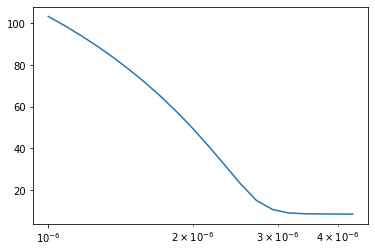

In [84]:
plt.semilogx(history.history['lr'], history.history['val_loss'])

In [85]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=(window_size,))
])

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-6, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])

stopper = tf.keras.callbacks.EarlyStopping(patience=10)

epochs = 200
history = model.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=[stopper])
model.summary()

Epoch 1/200
34/34 [==============================] - 1s 8ms/step - loss: 76.6879 - mae: 77.1879 - val_loss: 84.4892 - val_mae: 84.9892
Epoch 2/200
34/34 [==============================] - 0s 5ms/step - loss: 37.2736 - mae: 37.7726 - val_loss: 24.3225 - val_mae: 24.8218
Epoch 3/200
34/34 [==============================] - 0s 5ms/step - loss: 10.8119 - mae: 11.3028 - val_loss: 9.1132 - val_mae: 9.5971
Epoch 4/200
34/34 [==============================] - 0s 5ms/step - loss: 9.8147 - mae: 10.3063 - val_loss: 8.7956 - val_mae: 9.2875
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 9.7710 - mae: 10.2617 - val_loss: 8.7737 - val_mae: 9.2601
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 9.7617 - mae: 10.2513 - val_loss: 8.7624 - val_mae: 9.2463
Epoch 7/200
34/34 [==============================] - 0s 5ms/step - loss: 9.7360 - mae: 10.2272 - val_loss: 8.7547 - val_mae: 9.2452
Epoch 8/200
34/34 [==============================] - 0s 5ms/step - lo

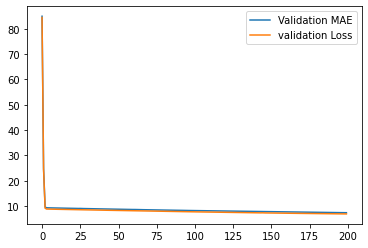

In [86]:
plt.plot(history.history['val_mae'], label="Validation MAE")
plt.plot(history.history['val_loss'], label="validation Loss")
plt.legend()

In [87]:
def model_forecast(model, series, window_size, batch_size=32):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda w: w.batch(window_size))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)

  return model.predict(dataset)

predictions = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

MAE 7.349905490875244


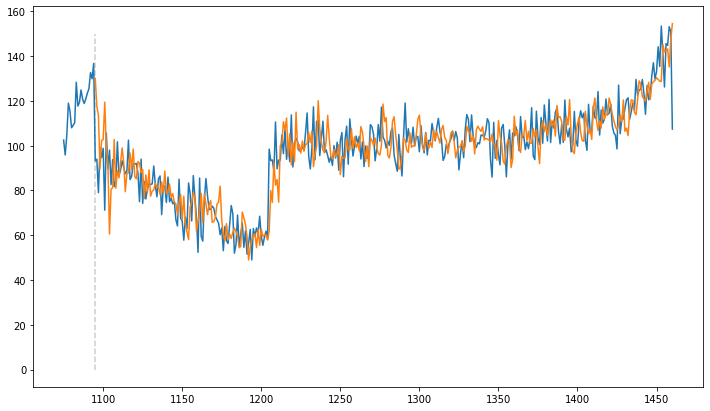

In [88]:
plt.figure(figsize=(12, 7))
plt.plot(time[split_time-20:],series[split_time-20:])
plt.plot(time_val, predictions)
plt.vlines(x=split_time, ymin=0, ymax=150, linestyles='dashed', alpha=0.2)
print("MAE", history.history['val_mae'][-1])

MAE 7.349905490875244


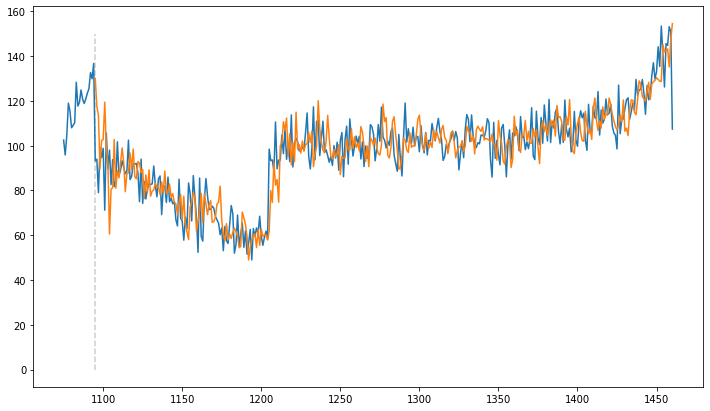

In [89]:
plt.figure(figsize=(12, 7))
plt.plot(time[split_time-20:],series[split_time-20:])
plt.plot(time_val, predictions)
plt.vlines(x=split_time, ymin=0, ymax=150, linestyles='dashed', alpha=0.2)
print("MAE", history.history['val_mae'][-1])